In [1]:
import numpy as np 
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import torch

# Synthetic data

## 0. Preparation 
First, run ``run_models.sh`` to obtain the necessary data for the figure. This script trains all prob. learners and saves the results to the folder ``./results``

## 1. Load predictive means, variances, RMSE and prediction interval coverage rates

In [131]:
methods = ['lli_closed_form', 'lli_vi_closed_form', 'lli_vi_ridge', 'lli_vi_horseshoe',  'lli_gibbs_ridge', 'lli_vi_ridge_full_fac',  'lli_vi_horseshoe_full_fac',  'mc_dropout', 'bnn']
method_names = ['LLI + Gauss + closed form', 'LLI + VI + closed-form + fullCov', 'LLI + VI + Ridge + diagCov',  'LLI + VI + Horseshoe + diagCov', 'LLI + Ridge + Gibbs',  'LLI + Ridge + VFAC', 'LLI + Horseshoe + VFAC', 'MC dropout', 'BNN']
#  'lli_vi_ridge', 'lli_vi_horseshoe', 'lli_gibbs_ridge',  , lli_vi_fac_ridge, lli_vi_fac_horseshoe
dict_list = []
for method in methods:
    out_dict_path = Path(f"./results/out_dict_{method}_synthetic.pkl")

    with open(out_dict_path, "rb") as f:
        loaded_dict = pickle.load(f)
    dict_list.append(loaded_dict.copy())

In [132]:
linestyles =  ['dashed', '-','dashdot', (0, (1, 1)), (0, (3, 5, 1, 5, 1, 5)),  (0, (3, 1, 1, 1)),  (0, (3, 1, 1, 1, 1, 1)), 'dotted', (0, (5, 1))] # ,  (0, (3, 5, 1, 5, 1, 5))

In [6]:
def get_rmse_mean_std(errors, n_boot =1000):
    rmse_boot = []
    for _ in range(n_boot):
        idx = np.random.choice(len(errors), len(errors), replace=True)
        rmse_boot.append(np.sqrt((errors[idx]**2).mean()))

    rmse_boot = np.array(rmse_boot)
    rmse_mean = rmse_boot.mean()
    rmse_std = rmse_boot.std()
    return rmse_mean, rmse_std

## 1. Coverage rates

In [ ]:

levels = np.linspace(0.001, 0.99, 100)
fig, axs = plt.subplots(1,1, figsize = (8,5))
for method, method_dict, name, linestyle in zip(methods, dict_list, method_names, linestyles):
    axs.plot(levels,  np.abs(levels - method_dict['coverage']), 
                    color = 'black', label = name, linestyle = linestyle
                    )
#axs.legend()
axs.axhline(y=0, color='black', linestyle='-', 
            linewidth=2, label='Ideal', alpha = .1)
axs.legend(loc = 'center right', ncols = 1, fontsize = 10, bbox_to_anchor=(1.58, 0.5)) #
axs.set_xticks(np.arange(-1, 1, .5))
axs.set_yticks(np.arange(-0.25, 1.5, .25))
axs.set_xlim(-0, 1.1)
axs.set_ylim(-.25, .8)
axs.set_title(f'Coverage of Prediction Intervals', pad = 20, size = 20)
axs.grid(False)
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.set_xlabel('prediction interval level', fontsize = 20)
axs.set_ylabel('predicted - actual coverage rate', fontsize = 20)
x_text = 0.15
axs.text(x_text, -0.2, 'Underconfident', fontsize=15, color='black', ha='center', alpha = 0.6)
axs.text(x_text, 0.6, 'Overconfident', fontsize=15, color='black', ha='center', alpha = 0.6)


header_style = dict(linestyle='', color='black', marker='', alpha=0)

# careful! The linestyles here are specified by hand.
legend_elements = [
    Line2D([], [], **header_style, label="LLI"),
    Line2D([0], [0], color='black', linestyle='dashed', label='closed-form Gaussian'),
    Line2D([0], [0], color='black', linestyle='-', label='VI + full cov.'),
    Line2D([0], [0], color='black', linestyle='dashdot', label='VI + Ridge + diagCov'),
    Line2D([0], [0], color='black', linestyle=(0, (1, 1)), label='VI + Horseshoe + diagCov'),
    Line2D([0], [0], color='black', linestyle=(0, (3, 5, 1, 5, 1, 5)), label='Gibbs + Ridge'),
    Line2D([0], [0], color='black', linestyle= (0, (3, 1, 1, 1)), label='VFAC + Ridge'),
    Line2D([0], [0], color='black', linestyle= (0, (3, 1, 1, 1, 1, 1)), label='VFAC + Horseshoe'),
    Line2D([], [], **header_style, label=""),

    Line2D([0], [0], color='black', linestyle='dotted', label='MC dropout'),
    Line2D([0], [0], color='black', linestyle=(0, (5, 1)), label='BNN'),
]

axs.legend(handles=legend_elements, loc='center right', fontsize=13, bbox_to_anchor=(1.58, 0.5))
fig.savefig('figures/coverage_synthetic.pdf', bbox_inches = 'tight')

## 2. RMSE plot

In [127]:
data_file = Path("./results/synthetic_data.npz")
data = np.load(data_file)
xs_train = torch.tensor(data["xs_train"])
ys_train = torch.tensor(data["ys_train"])
xs_val   = torch.tensor(data["xs_val"])
ys_val   = torch.tensor(data["ys_val"])

In [ ]:
plt.rcParams.update({'font.size': 15, 
                    "font.family": "serif",
                    "font.serif": ["Times New Roman"]})

num_points = 5   # number of methods or configurations per panel
markers = ['o', 's', 'D', '^', 'v', '*', 'P', '>', '<' ]
# Create horizontal subplots
fig, axs = plt.subplots(1, 1, figsize=(5, 4), sharey=False)

for i, (method_dict, label) in enumerate(zip(dict_list, 
                                    method_names)):
    errors = dict_list[i]['pred_mu'].squeeze() - np.array(ys_val)
    rmse_mean, rmse_std = get_rmse_mean_std(errors, n_boot =1000)
    axs.errorbar(
        x=i, 
        y=rmse_mean, 
        yerr=rmse_std, 
        fmt=markers[i], 
        color='black', 
        markersize=10, 
        capsize=3,
        linewidth=2,
        markeredgewidth=1.5,
        label = label,
    )
axs.set_xticks([])
#axs.set_yticks([0, .5,  1, 2,  2])
axs.set_xlim(-0.5, 9)
#axs.set_ylim(0, 2.5)
axs.set_title(f'Performance', pad = 20, size = 20)
axs.grid(False)
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.set_xlabel('Method', fontsize = 20)
axs.set_ylabel('test RMSE', fontsize = 20)
axs.legend(loc='center right', fontsize=13, bbox_to_anchor=(2.05, 0.5))

ymin, ymax = axs.get_ylim()
offset = (ymax - ymin) * 0.15

plt.tight_layout()
plt.show()
fig.savefig('figures/rmse_synthetic.pdf', bbox_inches = 'tight')

# Concrete Compressive Strength

In [117]:
methods = ['lli_closed_form', 'lli_vi_closed_form', 'lli_vi_ridge', 'lli_vi_horseshoe',  'lli_gibbs_ridge', 'lli_vi_ridge_full_fac',  'lli_vi_horseshoe_full_fac',  'mc_dropout', 'bnn']
method_names = ['LLI + Gauss + closed form', 'LLI + VI + closed-form + fullCov', 'LLI + VI + Ridge + diagCov',  'LLI + VI + Horseshoe + diagCov', 'LLI + Ridge + Gibbs',  'LLI + Ridge + VFAC', 'LLI + Horseshoe + VFAC', 'MC dropout', 'BNN']
#   'lli_vi_ridge', 'lli_vi_horseshoe', 'lli_gibbs_ridge',  , lli_vi_fac_ridge, lli_vi_fac_horseshoe
dict_list = []
for method in methods:
    out_dict_path = Path(f"./results/out_dict_{method}_concrete.pkl")

    with open(out_dict_path, "rb") as f:
        loaded_dict = pickle.load(f)
    dict_list.append(loaded_dict.copy())

In [118]:
data_file = Path("./results/concrete_data.npz")
data = np.load(data_file)
xs_train = torch.tensor(data["xs_train"])
ys_train = torch.tensor(data["ys_train"])
xs_val   = torch.tensor(data["xs_val"])
ys_val   = torch.tensor(data["ys_val"])

In [119]:
linestyles =  ['dashed', '-','dashdot', (0, (1, 1)), (0, (3, 5, 1, 5, 1, 5)),  (0, (3, 1, 1, 1)),  (0, (3, 1, 1, 1, 1, 1)), 'dotted', (0, (5, 1))] # ,  (0, (3, 5, 1, 5, 1, 5))

In [ ]:

levels = np.linspace(0.001, 0.99, 100)
fig, axs = plt.subplots(1,1, figsize = (8,5))
for method, method_dict, name, linestyle in zip(methods, dict_list, method_names, linestyles):
    axs.plot(levels,  np.abs(levels - method_dict['coverage']), 
                    color = 'black', label = name, linestyle = linestyle
                    )
#axs.legend()
axs.axhline(y=0, color='black', linestyle='-', 
            linewidth=2, label='Ideal', alpha = .1)
axs.legend(loc = 'center right', ncols = 1, fontsize = 10, bbox_to_anchor=(1.58, 0.5)) #
axs.set_xticks(np.arange(-1, 1, .5))
axs.set_yticks(np.arange(-0.25, 1.5, .25))
axs.set_xlim(-0, 1.1)
axs.set_ylim(-.25, .8)
axs.set_title(f'Coverage of Prediction Intervals', pad = 20, size = 20)
axs.grid(False)
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.set_xlabel('prediction interval level', fontsize = 20)
axs.set_ylabel('predicted - actual coverage rate', fontsize = 20)
x_text = 0.15
axs.text(x_text, -0.2, 'Underconfident', fontsize=15, color='black', ha='center', alpha = 0.6)
axs.text(x_text, 0.6, 'Overconfident', fontsize=15, color='black', ha='center', alpha = 0.6)


header_style = dict(linestyle='', color='black', marker='', alpha=0)

# careful! The linestyles here are specified by hand.
legend_elements = [
    Line2D([], [], **header_style, label="LLI"),
    Line2D([0], [0], color='black', linestyle='dashed', label='closed-form Gaussian'),
    Line2D([0], [0], color='black', linestyle='-', label='VI + full cov.'),
    Line2D([0], [0], color='black', linestyle='dashdot', label='VI + Ridge + diagCov'),
    Line2D([0], [0], color='black', linestyle=(0, (1, 1)), label='VI + Horseshoe + diagCov'),
    Line2D([0], [0], color='black', linestyle=(0, (3, 5, 1, 5, 1, 5)), label='Gibbs + Ridge'),
    Line2D([0], [0], color='black', linestyle= (0, (3, 1, 1, 1)), label='VFAC + Ridge'),
    Line2D([0], [0], color='black', linestyle= (0, (3, 1, 1, 1, 1, 1)), label='VFAC + Horseshoe'),
    Line2D([], [], **header_style, label=""),

    Line2D([0], [0], color='black', linestyle='dotted', label='MC dropout'),
    Line2D([0], [0], color='black', linestyle=(0, (5, 1)), label='BNN'),
]

axs.legend(handles=legend_elements, loc='center right', fontsize=13, bbox_to_anchor=(1.58, 0.5))
fig.savefig('figures/coverage_concrete.pdf', bbox_inches = 'tight')

In [ ]:
plt.rcParams.update({'font.size': 15, 
                    "font.family": "serif",
                    "font.serif": ["Times New Roman"]})

num_points = 5   # number of methods or configurations per panel
markers = ['o', 's', 'D', '^', 'v', '*', 'P', '>', '<' ]
# Create horizontal subplots
fig, axs = plt.subplots(1, 1, figsize=(5, 4), sharey=False)

for i, (method_dict, label) in enumerate(zip(dict_list, 
                                    method_names)):
    errors = dict_list[i]['pred_mu'].squeeze() - np.array(ys_val)
    rmse_mean, rmse_std = get_rmse_mean_std(errors, n_boot =1000)
    axs.errorbar(
        x=i, 
        y= rmse_mean,
        yerr=rmse_std,
        fmt=markers[i], 
        color='black', 
        markersize=10, 
        capsize=3,
        linewidth=2,
        markeredgewidth=1.5,
        label = label,
    )
axs.set_xticks([])
#axs.set_yticks([0, .5,  1, 2,  2])
#axs.set_xlim(-0.5, 9)
#axs.set_ylim(0, 2.5)
axs.set_title(f'Performance', pad = 20, size = 20)
axs.grid(False)
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.set_xlabel('Method', fontsize = 20)
axs.set_ylabel('test RMSE', fontsize = 20)
axs.legend(loc='center right', fontsize=13, bbox_to_anchor=(2.05, 0.5))

ymin, ymax = axs.get_ylim()
offset = (ymax - ymin) * 0.15

plt.tight_layout()
plt.show()
fig.savefig('figures/rmse_concrete.pdf', bbox_inches = 'tight')

# Joint plot

## Coverage

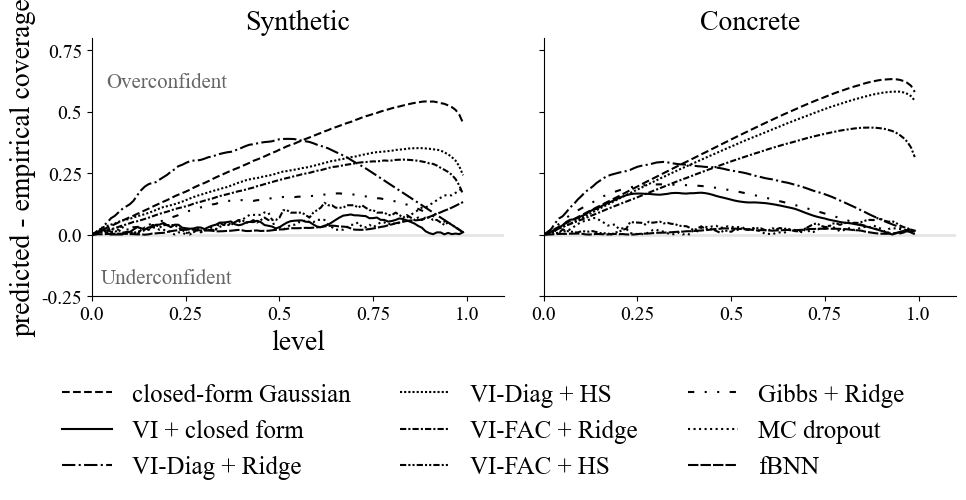

In [94]:
plt.rcParams.update({'font.size': 18, 
                    "font.family": "serif",
                    "font.serif": ["Times New Roman"]})

methods = ['lli_closed_form', 'lli_vi_closed_form', 'lli_vi_ridge', 'lli_vi_horseshoe',   'lli_vi_ridge_full_fac',  'lli_vi_horseshoe_full_fac', 'lli_gibbs_ridge',  'mc_dropout', 'bnn']
method_names = ['Gauss + closed form', 'VI + closed-form', 'VI-Diag + Ridge', 'VI-Diag + HS', 'VI-FAC + Ridge', 'VI-FAC + HS', 'Ridge + Gibbs', 'MC dropout', 'fBNN']
linestyles =  ['dashed', '-','dashdot', (0, (1, 1)), (0, (3, 5, 1, 5, 1, 5)),  (0, (3, 1, 1, 1)),  (0, (3, 1, 1, 1, 1, 1)), 'dotted', (0, (5, 1))] # ,  (0, (3, 5, 1, 5, 1, 5))

fig, axs = plt.subplots(1,2, figsize = (10,4))
levels = np.linspace(0.001, 0.99, 100)

# synthetic data
dict_list = []
for method in methods:
    out_dict_path = Path(f"./results/out_dict_{method}_synthetic.pkl")

    with open(out_dict_path, "rb") as f:
        loaded_dict = pickle.load(f)
    dict_list.append(loaded_dict.copy())
    
for method, method_dict, name, linestyle in zip(methods, dict_list, method_names, linestyles):
    axs[0].plot(levels,  np.abs(levels - method_dict['coverage']), 
                    color = 'black', label = name, linestyle = linestyle
                    )
#axs.legend()
axs[0].axhline(y=0, color='black', linestyle='-', 
            linewidth=2, label='Ideal', alpha = .1)
#axs[0].legend(loc = 'center right', ncols = 1, fontsize = 10, bbox_to_anchor=(1.58, 0.5)) #
axs[0].set_xticks(np.arange(0, 1.1, .25), labels = np.arange(0,1.1, .25), fontsize=14)
axs[0].set_yticks(np.arange(-0.25, 1.5, .25), labels = np.arange(-0.25, 1.5, .25), fontsize=14)
axs[0].set_xlim(-0, 1.1)
axs[0].set_ylim(-.25, .8)
#axs[0].set_title(f'Coverage of Prediction Intervals', pad = 20, size = 10)
axs[0].grid(False)
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].set_xlabel('level', fontsize = 20)
axs[0].set_ylabel('predicted - empirical coverage', fontsize = 20)
x_text = 0.2
axs[0].text(x_text, -0.2, 'Underconfident', fontsize=15, color='black', ha='center', alpha = 0.6)
axs[0].text(x_text, 0.6, 'Overconfident', fontsize=15, color='black', ha='center', alpha = 0.6)
axs[0].set_title('Synthetic', size = 20)

# concrete data
dict_list = []
for method in methods:
    out_dict_path = Path(f"./results/out_dict_{method}_concrete.pkl")

    with open(out_dict_path, "rb") as f:
        loaded_dict = pickle.load(f)
    dict_list.append(loaded_dict.copy())


data_file = Path("./results/concrete_data.npz")
data = np.load(data_file)
xs_train = torch.tensor(data["xs_train"])
ys_train = torch.tensor(data["ys_train"])
xs_val   = torch.tensor(data["xs_val"])
ys_val   = torch.tensor(data["ys_val"])

for method, method_dict, name, linestyle in zip(methods, dict_list, method_names, linestyles):
    axs[1].plot(levels,  np.abs(levels - method_dict['coverage']), 
                    color = 'black', label = name, linestyle = linestyle
                    )

axs[1].axhline(y=0, color='black', linestyle='-', 
            linewidth=2, label='Ideal', alpha = .1)
axs[1].set_xticks(np.arange(0, 1.1, .25), labels = np.arange(0,1.1, .25), fontsize=14)
#axs[1].set_xticklabels([])
axs[1].set_yticks(np.arange(-0.25, 1.5, .25))
axs[1].set_yticklabels([])
axs[1].set_xlim(-0, 1.1)
axs[1].set_ylim(-.25, .8)
axs[1].grid(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].set_title('Concrete', size = 20)
x_text = 0.2
#axs[1].text(x_text, -0.2, 'Underconfident', fontsize=15, color='black', ha='center', alpha = 0.6)
#axs[1].text(x_text, 0.6, 'Overconfident', fontsize=15, color='black', ha='center', alpha = 0.6)

header_style = dict(linestyle='', color='black', marker='', alpha=0)
# careful! these linestyle elements are specified by hand!
legend_elements = [
    #Line2D([], [], **header_style, label="LLI"),
    Line2D([0], [0], color='black', linestyle='dashed', label='closed-form Gaussian'),
    Line2D([0], [0], color='black', linestyle='-', label='VI + closed form'),
    Line2D([0], [0], color='black', linestyle='dashdot', label='VI-Diag + Ridge'),
    Line2D([0], [0], color='black', linestyle=(0, (1, 1)), label='VI-Diag + HS'),
    Line2D([0], [0], color='black', linestyle= (0, (3, 1, 1, 1)), label='VI-FAC + Ridge'),
    Line2D([0], [0], color='black', linestyle= (0, (3, 1, 1, 1, 1, 1)), label='VI-FAC + HS'),
    Line2D([0], [0], color='black', linestyle=(0, (3, 5, 1, 5, 1, 5)), label='Gibbs + Ridge'),
    
    #Line2D([], [], **header_style, label=""),

    Line2D([0], [0], color='black', linestyle='dotted', label='MC dropout'),
    Line2D([0], [0], color='black', linestyle=(0, (5, 1)), label='fBNN'),
]

fig.tight_layout()
fig.legend(handles=legend_elements, loc='lower center', frameon=False, ncol=3, fontsize=18, bbox_to_anchor=(0.5, -0.3))
fig.savefig('figures/coverage.pdf', bbox_inches = 'tight')

## RMSE

/var/folders/73/tcv3sgb138b9cqckw4zk9r5h0000gn/T/ipykernel_2676/3235129556.py:22: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  errors = dict_list[i]['pred_mu'].squeeze() - np.array(ys_val)
/var/folders/73/tcv3sgb138b9cqckw4zk9r5h0000gn/T/ipykernel_2676/3235129556.py:22: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  errors = dict_list[i]['pred_mu'].squeeze() - np.array(ys_val)
/var/folders/73/tcv3sgb138b9cqckw4zk9r5h0000gn/T/ipykernel_2676/2885626310.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rmse_boot.append(np.sqrt((errors[idx]**2).mean()

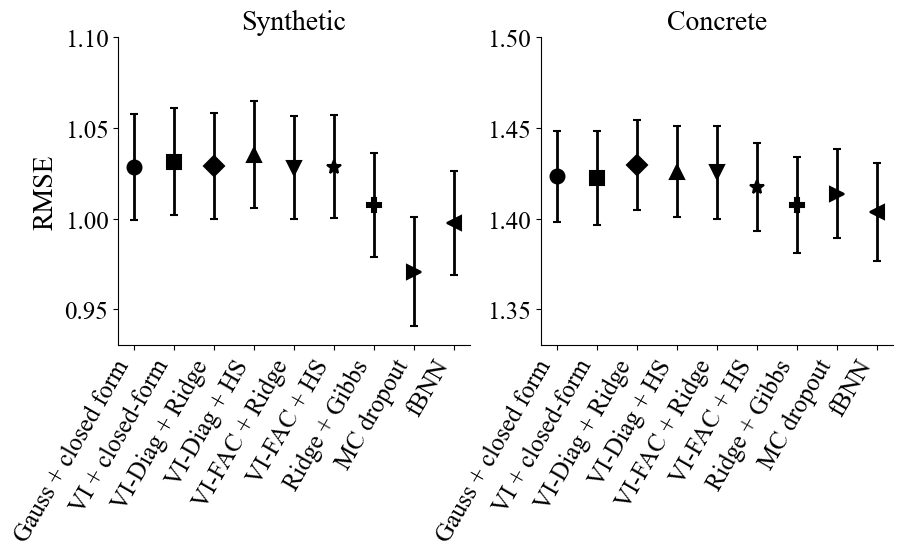

In [95]:
markers = ['o', 's', 'D', '^', 'v', '*', 'P', '>', '<' ]
fig, axs = plt.subplots(1,2, figsize = (10,4))

# synthetic data
dict_list = []
for method in methods:
    out_dict_path = Path(f"./results/out_dict_{method}_synthetic.pkl")

    with open(out_dict_path, "rb") as f:
        loaded_dict = pickle.load(f)
    dict_list.append(loaded_dict.copy())

data_file = Path("./results/synthetic_data.npz")
data = np.load(data_file)
xs_train = torch.tensor(data["xs_train"])
ys_train = torch.tensor(data["ys_train"])
xs_val   = torch.tensor(data["xs_val"])
ys_val   = torch.tensor(data["ys_val"])

for i, (method_dict, label) in enumerate(zip(dict_list, 
                                    method_names)):
    errors = dict_list[i]['pred_mu'].squeeze() - np.array(ys_val)
    rmse_mean, rmse_std = get_rmse_mean_std(errors, n_boot =1000)
    axs[0].errorbar(
        x=i, 
        y= rmse_mean,
        yerr=rmse_std,
        fmt=markers[i], 
        color='black', 
        markersize=10, 
        capsize=3,
        linewidth=2,
        markeredgewidth=1.5,
        label = label,
    )
#axs[0].set_xticks([])
axs[0].grid(False)
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].set_ylabel('RMSE', fontsize = 20)
axs[0].legend(loc='center right', fontsize=13, bbox_to_anchor=(2.05, 0.5))
axs[0].set_title(f'Synthetic', size = 20)
axs[0].set_ylim(.93, 1.1)
axs[0].set_yticks(np.arange(.95, 1.11, 0.05))

dict_list = []
for method in methods:
    out_dict_path = Path(f"./results/out_dict_{method}_concrete.pkl")

    with open(out_dict_path, "rb") as f:
        loaded_dict = pickle.load(f)
    dict_list.append(loaded_dict.copy())


data_file = Path("./results/concrete_data.npz")
data = np.load(data_file)
xs_train = torch.tensor(data["xs_train"])
ys_train = torch.tensor(data["ys_train"])
xs_val   = torch.tensor(data["xs_val"])
ys_val   = torch.tensor(data["ys_val"])


for i, (method_dict, label) in enumerate(zip(dict_list, 
                                    method_names)):
    errors = dict_list[i]['pred_mu'].squeeze() - np.array(ys_val)
    rmse_mean, rmse_std = get_rmse_mean_std(errors, n_boot =1000)
    axs[1].errorbar(
        x=i, 
        y= rmse_mean,
        yerr=rmse_std,
        fmt=markers[i], 
        color='black', 
        markersize=10, 
        capsize=3,
        linewidth=2,
        markeredgewidth=1.5,
        label = label,
    )
axs[1].set_xticks([])
axs[1].set_ylim(1.33, 1.5)
axs[1].set_yticks(np.arange(1.35, 1.51, 0.05))
axs[1].grid(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].set_title('Concrete', size = 20)

axs[0].set_xticks(np.arange(0, 9, 1))
axs[0].set_xticklabels(method_names, rotation=60, ha='right')

axs[1].set_xticks(np.arange(0, 9, 1))
axs[1].set_xticklabels(method_names, rotation=60, ha='right')

#axs[0].legend( loc='lower center', ncol=3, fontsize=14, bbox_to_anchor=(1, -0.5))

fig.savefig('figures/rmse.pdf', bbox_inches = 'tight')


In [97]:
# horseshoe VI diag + VI fac

dict_list = []
for method in methods:
    out_dict_path = Path(f"./results/out_dict_{method}_synthetic.pkl")

    with open(out_dict_path, "rb") as f:
        loaded_dict = pickle.load(f)
    dict_list.append(loaded_dict.copy())

data_file = Path("./results/synthetic_data.npz")
data = np.load(data_file)
xs_train = torch.tensor(data["xs_train"])
ys_train = torch.tensor(data["ys_train"])
xs_val   = torch.tensor(data["xs_val"])
ys_val   = torch.tensor(data["ys_val"])

for i in [3, 5]:
    errors = dict_list[i]['pred_mu'].squeeze() - np.array(ys_val)
    rmse_mean, rmse_std = get_rmse_mean_std(errors, n_boot =1000)
    print(rmse_mean)

1.0357568
1.0287648


/var/folders/73/tcv3sgb138b9cqckw4zk9r5h0000gn/T/ipykernel_2676/725903262.py:19: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  errors = dict_list[i]['pred_mu'].squeeze() - np.array(ys_val)
